<a href="https://colab.research.google.com/github/tidaltamu/workshops/blob/main/special_topics/workshop2/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, lets generate some toy data – a simple binary classification problem that’s not linearly separable.
The goal of binary classification is to categorise data points into one of two buckets: 0 or 1, true or false, to survive or not to survive, blue or no blue eyes, etc.


In [ ]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm   #https://docs.pymc.io/
import seaborn as sns
import sklearn
import theano
import theano.tensor as T

from sklearn import datasets
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [ ]:
%config InlineBackend.figure_format = 'retina'
floatX = theano.config.floatX
filterwarnings("ignore")
sns.set_style("white")

In [ ]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000) #Make two interleaving half circles.
X = scale(X) #Standardize a dataset along any axis.

X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)


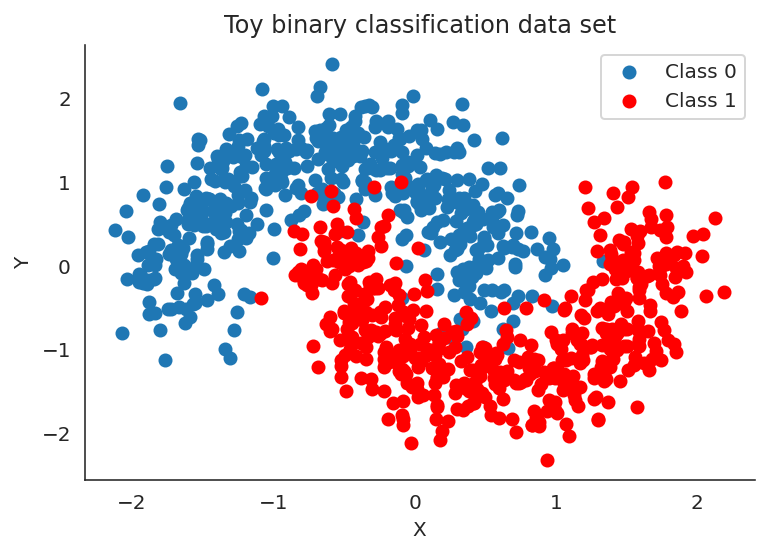

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X[Y == 0, 0], X[Y == 0, 1], label="Class 0")
#Thus X[y==0,0] finds all the rows of X that have a y value of 0 (y == 0), and are in the first column of X
ax.scatter(X[Y == 1, 0], X[Y == 1, 1], color="r", label="Class 1")
sns.despine() #Remove the top and right spines from plot(s).
#Spines are the lines connecting the axis tick marks and noting the boundaries of the data area. They can be placed at arbitrary positions.
ax.legend()
ax.set(xlabel="X", ylabel="Y", title="Toy binary classification data set");

Model specification 
- Here we will use 2 hidden layers with 5 neurons each which is sufficient for such a simple problem

In [ ]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network: #creates a new Model object which is a container for the model random variables.


        ann_input = pm.Data("ann_input", X_train) #lets the model be aware of its inputs and outputs.
        ann_output = pm.Data("ann_output", Y_train) #lets the model be aware of its inputs and outputs.

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal("w_in_1", 0, sigma=1, shape=(X.shape[1], n_hidden), testval=init_1) #    # Priors for unknown model parameters

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal("w_1_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, shape=(n_hidden,), testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli(
            "out",
            act_out,
            observed=ann_output,
            total_size=Y_train.shape[0],  # IMPORTANT for minibatches
        )

        #Bernoulli log-likelihood
        #The Bernoulli distribution describes the probability of successes (x=1) and failures (x=0). The pmf of this distribution is

        # f(x∣p)=px(1−p)1−x
        
    return neural_network


neural_network = construct_nn(X_train, Y_train)

- The Normal priors help regularize the weights


 ADVI variational inference algorithm which was recently added to PyMC3, and updated to use the operator variational inference (OPVI) framework. This is much faster and will scale better. 
 - he variational inference (VI) API is focused on approximating posterior distributions for Bayesian models.

In [ ]:
from pymc3.theanof import MRG_RandomStreams, set_tt_rng

set_tt_rng(MRG_RandomStreams(42))

In [ ]:
%%time

with neural_network:
    inference = pm.ADVI()  #advi: Run ADVI to estimate posterior mean and diagonal mass matrix.
    # for more info on ADVI go to : https://luiarthur.github.io/statorial/varinf/introvi/
    approx = pm.fit(n=30000, method=inference)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 127.93: 100%|██████████| 30000/30000 [00:39<00:00, 760.25it/s]
Finished [100%]: Average Loss = 127.97


CPU times: user 35.3 s, sys: 3.3 s, total: 38.6 s
Wall time: 1min 24s


Plotting the objective function (ELBO) we can see that the optimization slowly improves the fit over time.



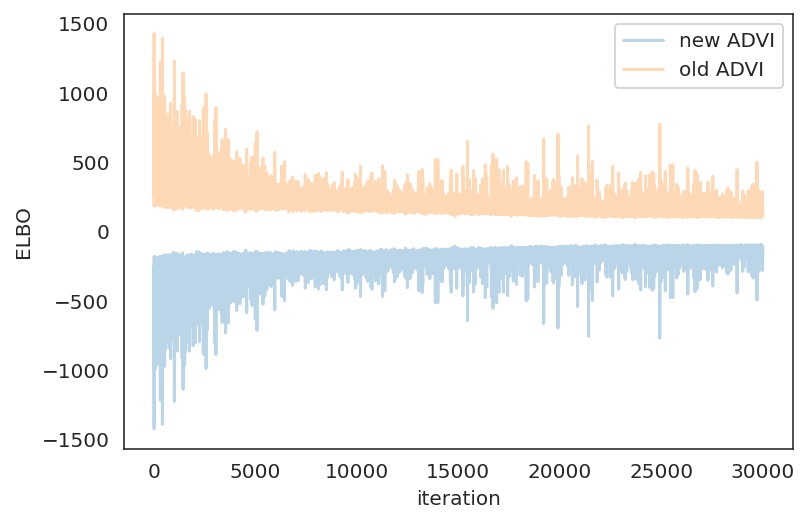

In [ ]:
plt.plot(-inference.hist, label="new ADVI", alpha=0.3)
plt.plot(approx.hist, label="old ADVI", alpha=0.3)
plt.legend()
plt.ylabel("ELBO")
plt.xlabel("iteration");
trace = approx.sample(draws=5000)


In [ ]:
# We can get predicted probability from model
neural_network.out.distribution.p

sigmoid.0

In [ ]:
# create symbolic input
x = T.matrix("X") #Return a Variable for a 2-dimensional ndarray

# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar("n")

# whenever you create a Theano variable, assign to it some value that will be used for debugging
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_train[:10])  #Return a new array with the same shape and type as a given array.

n.tag.test_value = 100
# To evaluate these expressions with the approximation,
_sample_proba = approx.sample_node(
    neural_network.out.distribution.p, size=n, more_replacements={neural_network["ann_input"]: x}
)
# It is time to compile the function
# No updates are needed for Approximation random generator
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x, n], _sample_proba) #the interface for compiling graphs into callable objects.

# Create bechmark functions
def production_step1():
    pm.set_data(new_data={"ann_input": X_test, "ann_output": Y_test}, model=neural_network)
    ppc = pm.sample_posterior_predictive(
        trace, samples=500, progressbar=False, model=neural_network
    )

    # Use probability of > 0.5 to assume prediction of class 1
    pred = ppc["out"].mean(axis=0) > 0.5


def production_step2():
    sample_proba(X_test, 500).mean(0) > 0.5


The %timeit magic decides how many times to run the specified expression based on its run time, and provides information not just about mean run time, but also the standard deviation over the ensemble of runs. 

In [ ]:
%timeit production_step1()


1 loop, best of 5: 5.29 s per loop


In [ ]:
%timeit production_step2()


10 loops, best of 5: 103 ms per loop


In [ ]:
pred = sample_proba(X_test, 500).mean(0) > 0.5


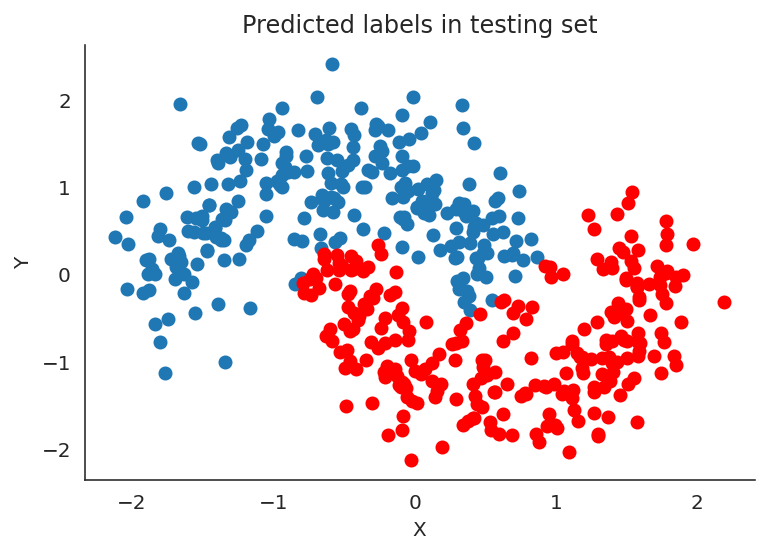

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1])
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="r")
sns.despine()
ax.set(title="Predicted labels in testing set", xlabel="X", ylabel="Y");

In [ ]:
print("Accuracy = {}%".format((Y_test == pred).mean() * 100))


Accuracy = 94.0%


For this, we evaluate the class probability predictions on a grid over the whole input space.



In [ ]:
grid = pm.floatX(np.mgrid[-3:3:100j, -3:3:100j]) #data is cast to floatX if it is not integer type 
# mgrid - nd_grid instance which returns a dense multi-dimensional “meshgrid”.

grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)
ppc = sample_proba(grid_2d, 500)


Probability surface

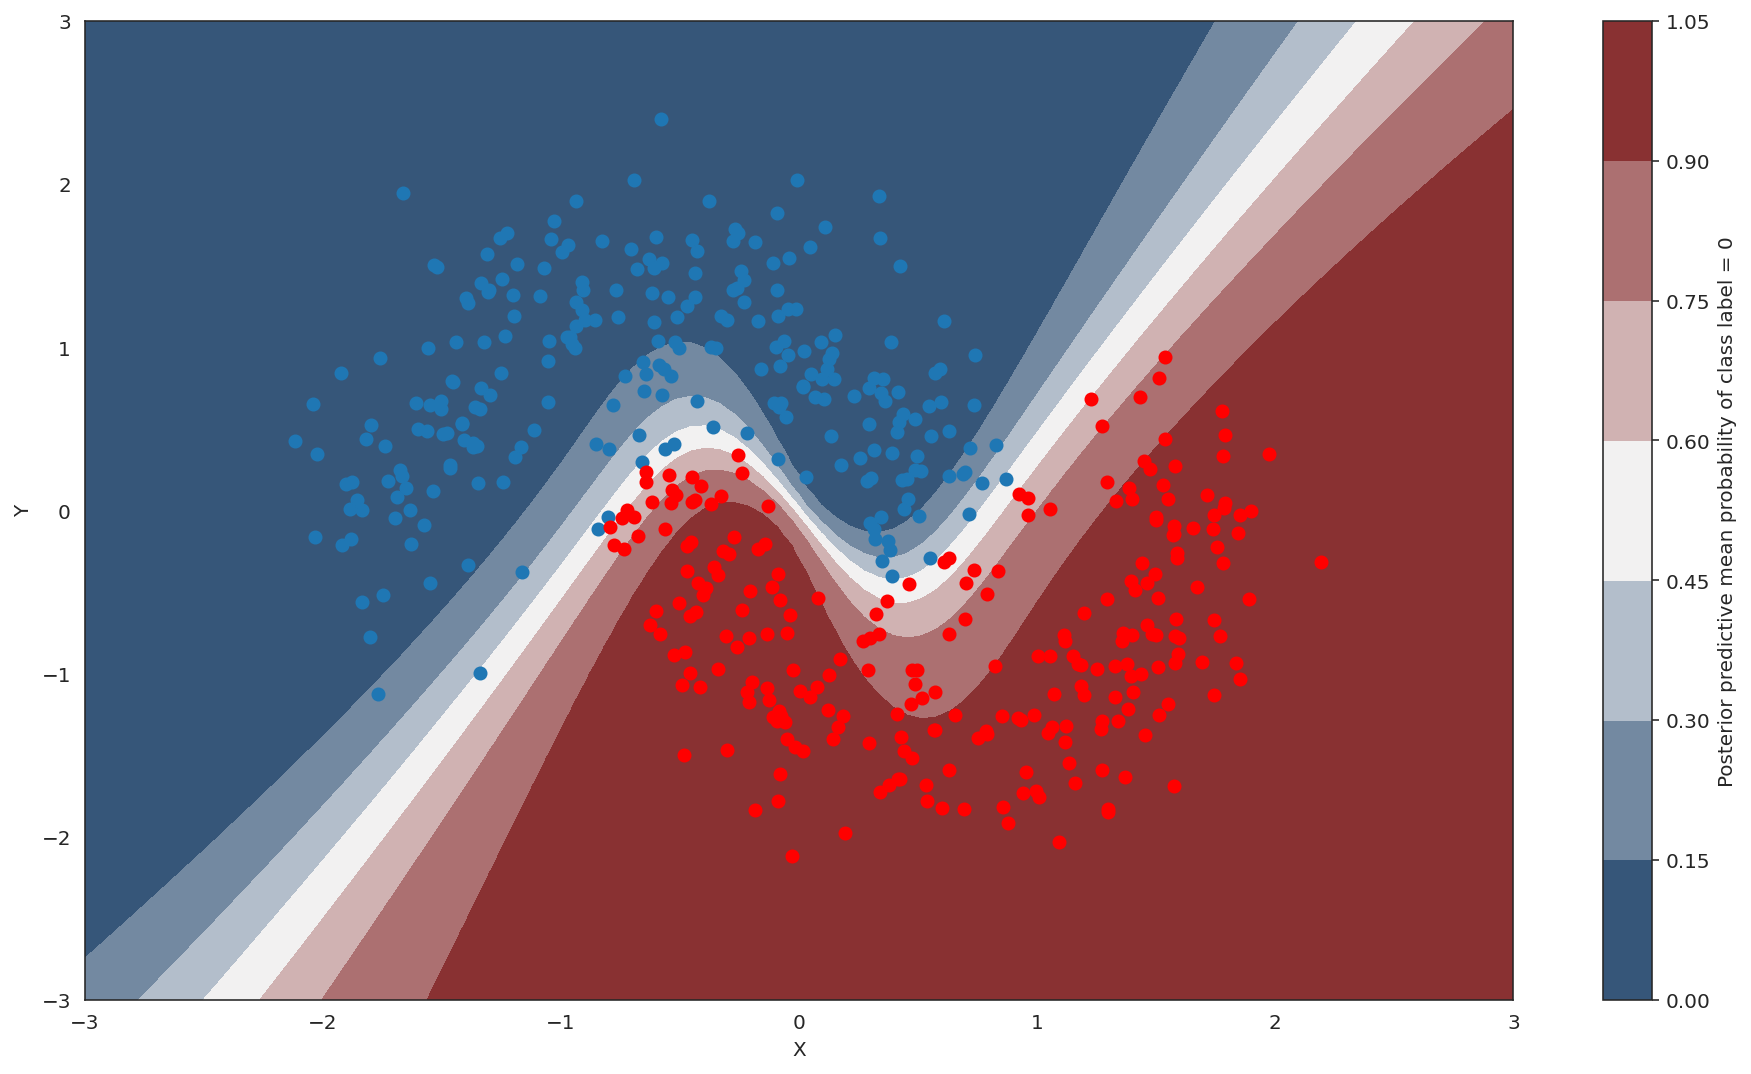

In [ ]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True) #Make a diverging palette between two HUSL colors.

fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap) #contour and contourf draw contour lines and filled contours
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1])
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="r")
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="X", ylabel="Y")
cbar.ax.set_ylabel("Posterior predictive mean probability of class label = 0");